In [127]:
# імпорт потрібних бібліотек
import requests
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LinearRegression

In [86]:
# Функція для завантаження даних
def download_document(file_name, document_url):
    if os.path.exists(file_name):
        print('File already downloaded.')
    else:
        response = requests.get(document_url)
        if response.status_code == 200:
            with open(file_name, 'wb') as f:
                f.write(response.content)
            print('File downloaded successfully.')
        else:
            print(f'Failed to download the document. Status code: {response.status_code}')

In [87]:
# отримуємо необхідний файл з даними
file_name = 'ikea.csv'
document_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'

download_document(file_name, document_url)

File already downloaded.


In [88]:
# Зчитуємо отриманні данні
ikea_df = pd.read_csv(file_name, sep = ',')
print(ikea_df)

# Основна інформація про набір даних
ikea_df.info()

# Описова статистика числових стовпців
ikea_df.describe()

# Описова статистика категоріальних стовпців
ikea_df.describe(include=['object'])

      Unnamed: 0   item_id                   name       category   price  \
0              0  90420332               FREKVENS  Bar furniture   265.0   
1              1    368814              NORDVIKEN  Bar furniture   995.0   
2              2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0   
3              3  80155205                   STIG  Bar furniture    69.0   
4              4  30180504                NORBERG  Bar furniture   225.0   
...          ...       ...                    ...            ...     ...   
3689        3689  99157902                ELVARLI      Wardrobes   750.0   
3690        3690   9158152                ELVARLI      Wardrobes  1572.0   
3691        3691  59157541                ELVARLI      Wardrobes   924.0   
3692        3692  89157573                ELVARLI      Wardrobes  2745.0   
3693        3693  69157376                ELVARLI      Wardrobes  1231.0   

         old_price  sellable_online  \
0     No old price             True   
1     No 

,name,category,old_price,link,other_colors,short_description,designer
count,3694,3694,3694,3694,3694,3694,3694
unique,607,17,365,2962,2,1706,381
top,BESTÅ,Tables & desks,No old price,https://www.ikea.com/sa/en/p/norraker-norraker...,No,Chair,IKEA of Sweden
freq,173,612,3040,4,2182,59,828


In [89]:
#перевірка на нульові значення
ikea_df.isnull()

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3690,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3691,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3692,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [90]:
#підрахуємо кількість нульових значень
ikea_df.isnull().sum()

Unnamed: 0              0
item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64

In [91]:
#розглянемо детальніше колонки
ikea_df.columns

Index(['Unnamed: 0', 'item_id', 'name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'],
      dtype='object')

In [92]:
#перевірка на дублікати по потрібним колонкам
ikea_df.duplicated(subset=['name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'])


#видалимо дублікати по 'item_id'
ikea_df.drop_duplicates(['item_id']).reset_index(drop=True)

#перевіримо чи видалися дублікати по 'item_id'
ikea_df.drop_duplicates(['item_id']).shape

#видалимо ці колонки,оскільки вони не несуть в собі важливої інформації
ikea_df = ikea_df.drop(['item_id', 'link', 'Unnamed: 0'], axis= 1)
ikea_df.columns #перевірка

Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width'],
      dtype='object')

In [93]:
#створимо функцію для очищення колонки 'designer'
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    if not isinstance(value, str):
        return value
    
    if len(value)>0 and value[0].isdigit():
        return emptyValue
    
    designers = value.split("/")
    
    if removeIKEA:
        try:
            designers.remove("IKEA of Sweden")
        except:
            pass
    if len(designers) > 0:
        return '/'.join(sorted(designers))
    else:
        return emptyValue

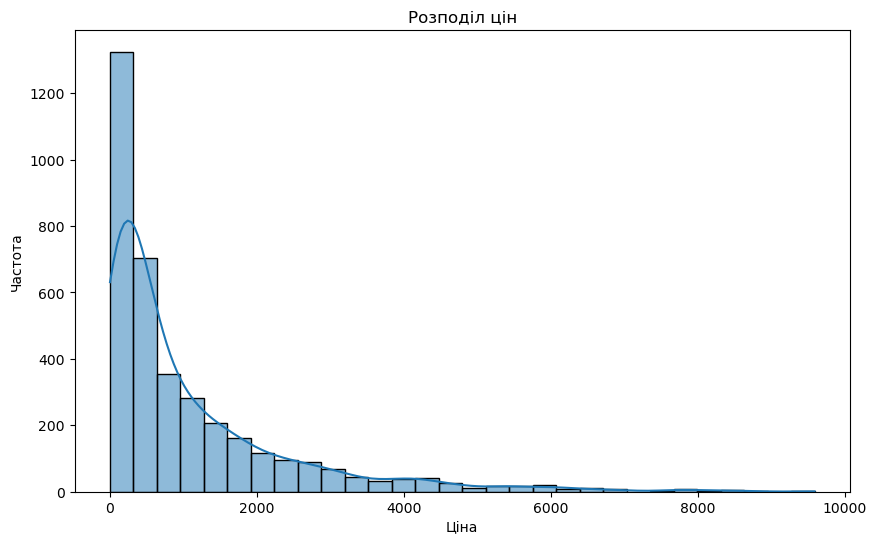

In [95]:
# Розподіл цін
plt.figure(figsize=(10, 6))
sns.histplot(ikea_df['price'], kde=True, bins=30)
plt.title('Розподіл цін')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

Більшість цін знаходяться в діапазоні до 200 одиниць валюти.

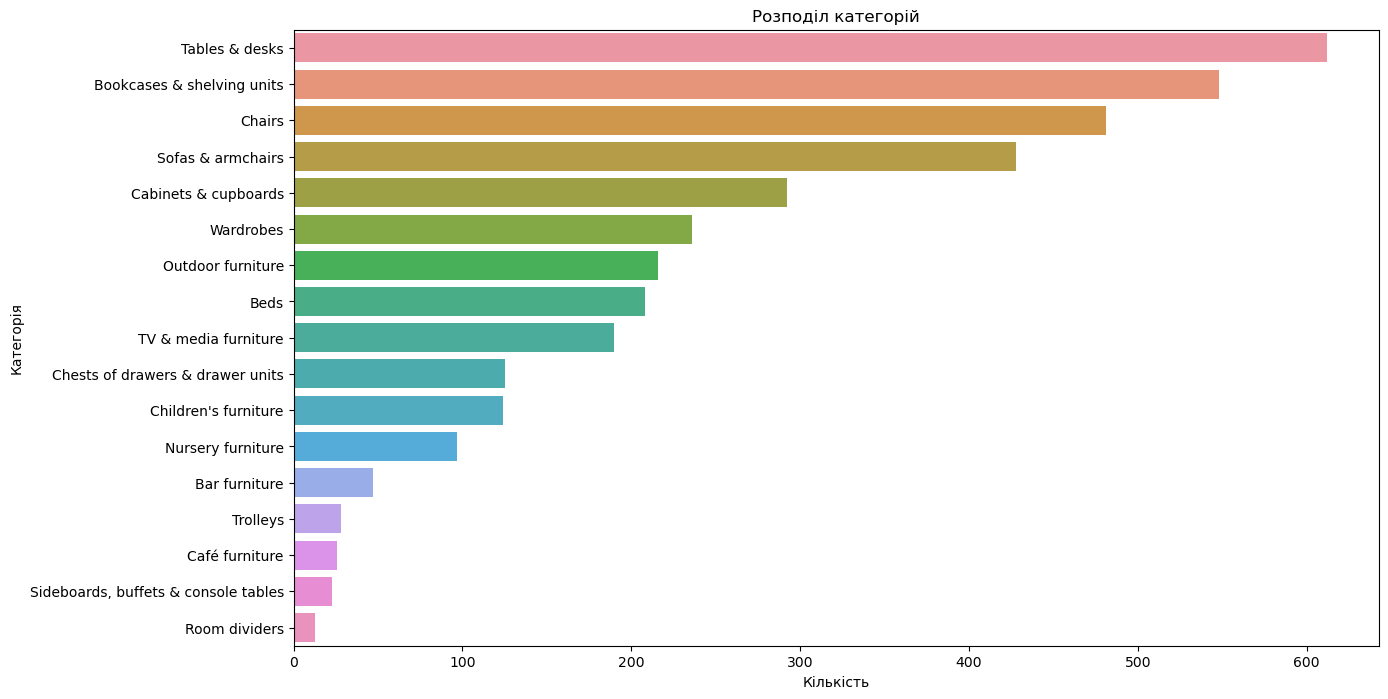

In [96]:
# Розподіл категорій
plt.figure(figsize=(14, 8))
sns.countplot(y='category', data=ikea_df, order=ikea_df['category'].value_counts().index)
plt.title('Розподіл категорій')
plt.xlabel('Кількість')
plt.ylabel('Категорія')
plt.show()

Найбільш поширені категорії - 'Tables & desks', 'Bookcases & shelving units', 'Chairs'.

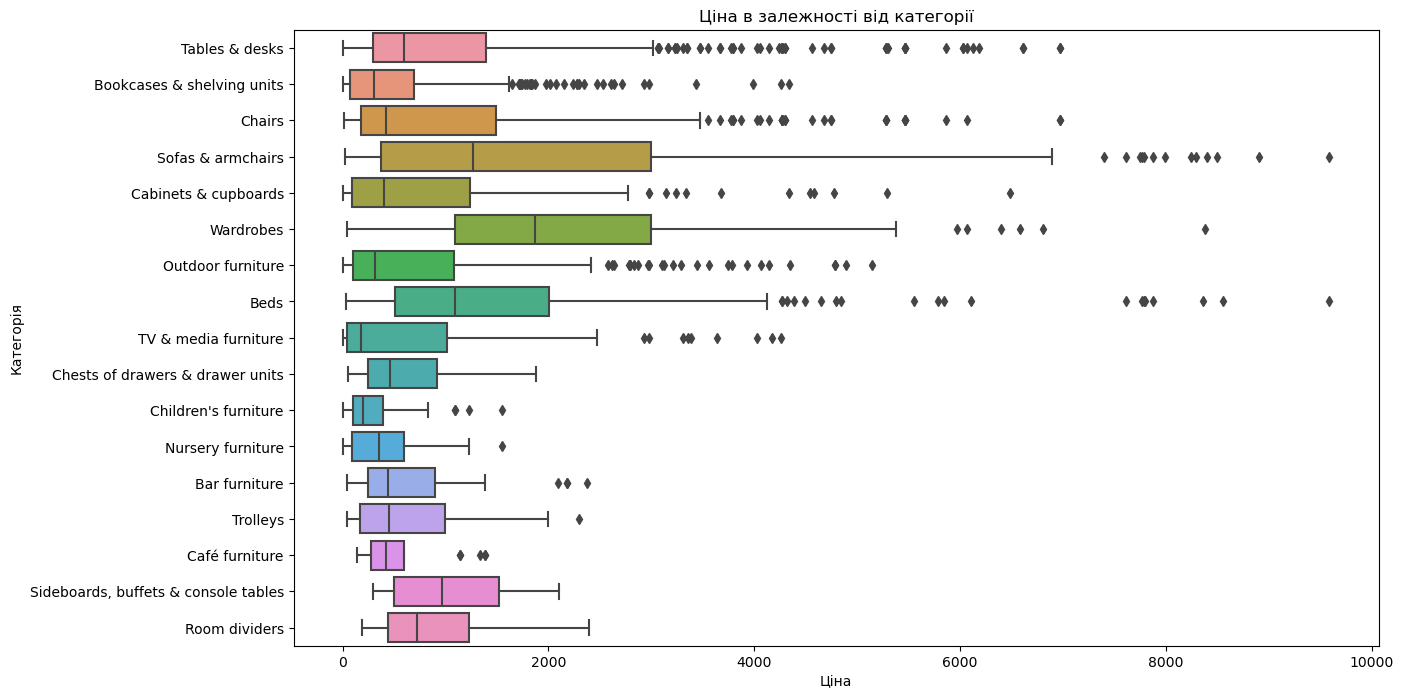

In [97]:
# Ціна в залежності від категорії
plt.figure(figsize=(14, 8))
sns.boxplot(y='category', x='price', data=ikea_df, order=ikea_df['category'].value_counts().index)
plt.title('Ціна в залежності від категорії')
plt.xlabel('Ціна')
plt.ylabel('Категорія')
plt.show()

Існує значна варіація цін в залежності від категорії товару.

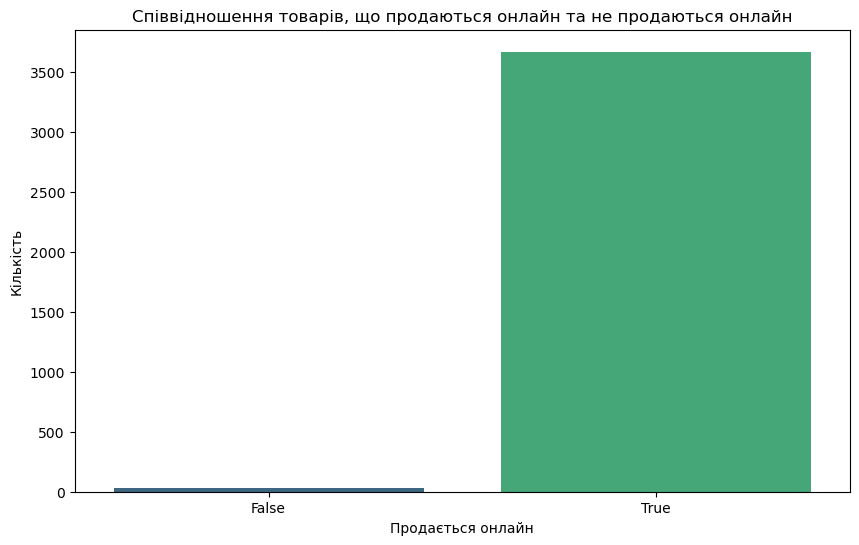

In [98]:
# Візуалізація співвідношення "продається / не продається онлайн"
plt.figure(figsize=(10, 6))
sns.countplot(x='sellable_online', data=ikea_df, palette='viridis')
plt.title('Співвідношення товарів, що продаються онлайн та не продаються онлайн')
plt.xlabel('Продається онлайн')
plt.ylabel('Кількість')
plt.show()

Ми бачимо, що більшість товарів - продаються онлайн.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


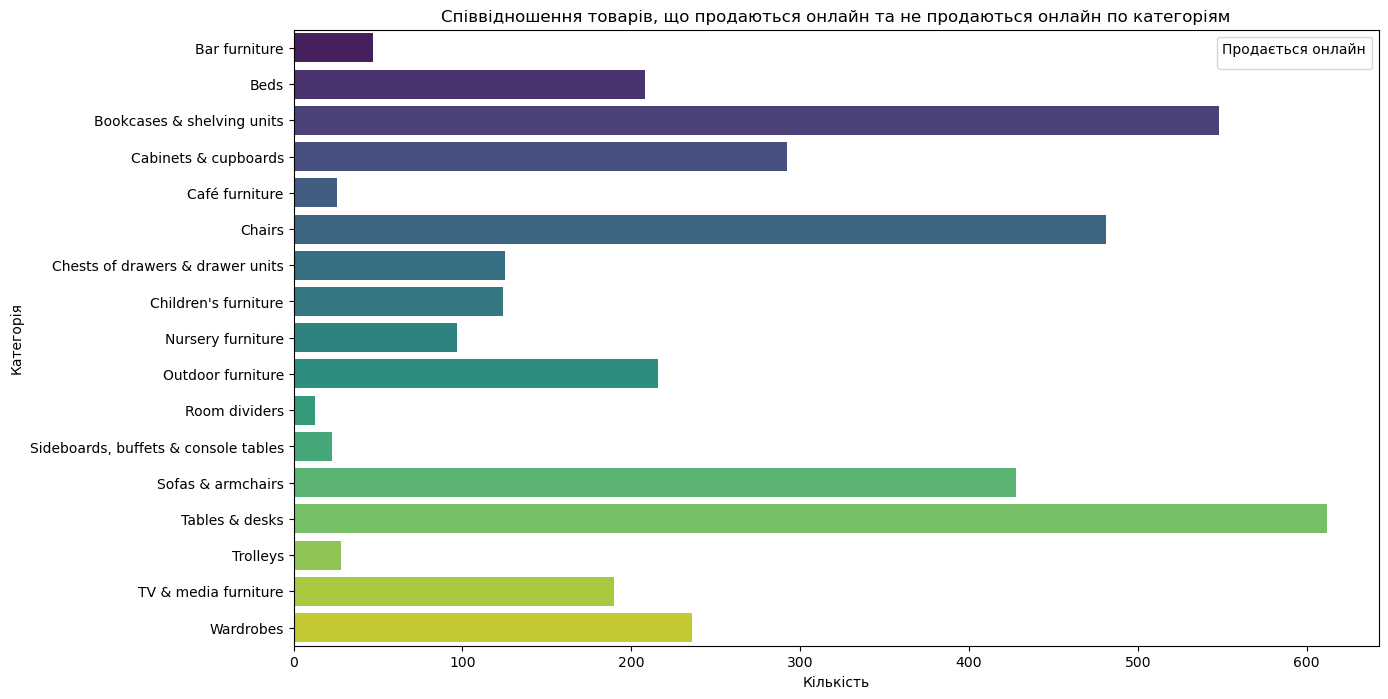

In [99]:
# Візуалізація співвідношення "продається / не продається онлайн" по категоріям
plt.figure(figsize=(14, 8))
sns.countplot(y='category', hue_order='sellable_online', data=ikea_df, palette='viridis')
plt.title('Співвідношення товарів, що продаються онлайн та не продаються онлайн по категоріям')
plt.xlabel('Кількість')
plt.ylabel('Категорія')
plt.legend(title='Продається онлайн')
plt.show()

Найбільше товарів, що продаються онлайн відносяться до категорії "Tables & desks"

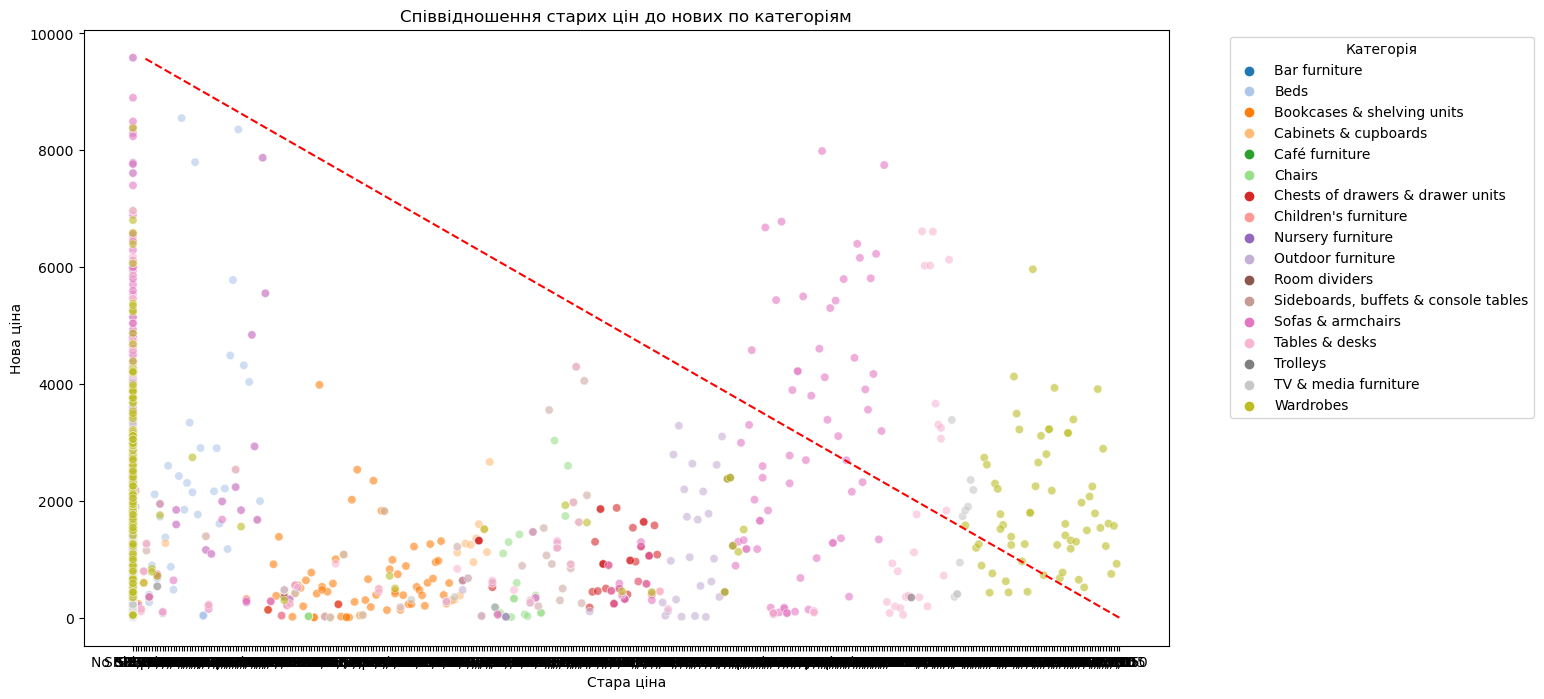

In [100]:
# Перевірка наявності old_price
if 'old_price' in ikea_df.columns:
    # Видалення записів з відсутніми значеннями old_price для точного аналізу
    ikea_with_old_price = ikea_df.dropna(subset=['old_price'])
    
    # Візуалізація співвідношення "old price / price" по категоріям
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='old_price', y='price', hue='category', data=ikea_with_old_price, alpha=0.6, palette='tab20')
    plt.title('Співвідношення старих цін до нових по категоріям')
    plt.xlabel('Стара ціна')
    plt.ylabel('Нова ціна')
    plt.plot([0, ikea_with_old_price['old_price'].max()], [0, ikea_with_old_price['price'].max()], color='red', linestyle='--')
    plt.legend(title='Категорія', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("Стовпець 'old_price' відсутній у наборі даних.")

Діаграма показує, як змінилися ціни на товари в різних категоріях, порівнюючи старі ціни з новими.
Червона пунктирна лінія на діаграмі показує, чи змінилися ціни: якщо точки знаходяться вище лінії, то нові ціни вищі за старі; якщо нижче, то нові ціни нижчі за старі.
Розбиття по категоріям дозволяє побачити, які категорії товарів мають найбільші зміни цін.

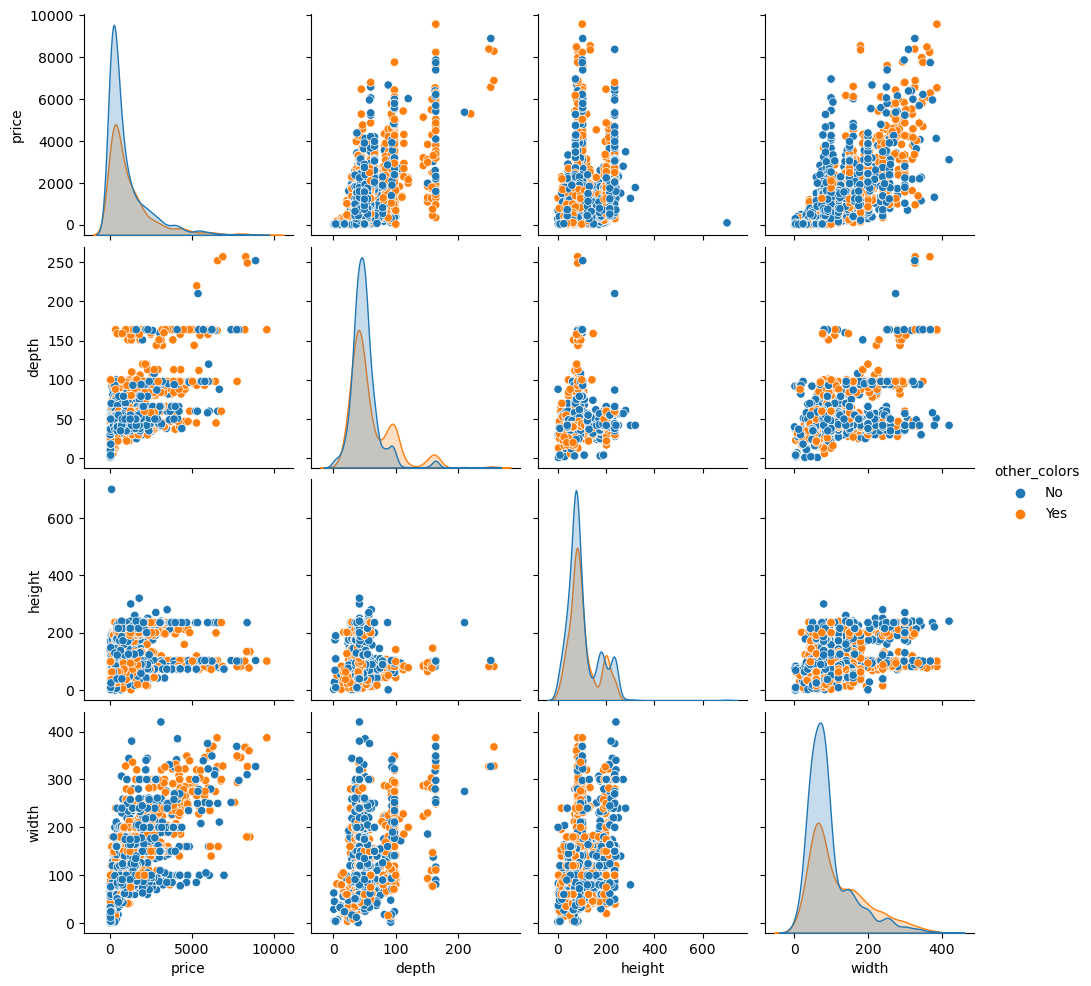

In [101]:
sns.pairplot(ikea_df[['price', 'depth', 'height', 'width', 'other_colors', 'category']], hue = 'other_colors')

Цікавими параметрами для ціноутворення виявилися ширина,висота,глибина

<Axes: >

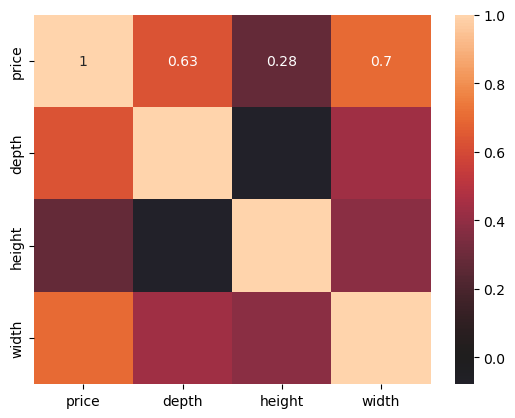

In [102]:
sns.heatmap(ikea_df[['price', 'depth', 'height', 'width']].corr(), xticklabels= ikea_df[['price', 'depth', 'height', 'width']].corr().columns,
            yticklabels= ikea_df[['price', 'depth', 'height', 'width']].corr().columns, center= 0, annot= True)

теплова карта свідчить про взаємозв'язок 'price' i 'width', 'depth','height'

Гіпотеза 1: Вплив категорії на ціну
Нульова гіпотеза (H0): Середні ціни для всіх категорій однакові.

Альтернативна гіпотеза (H1): Середні ціни відрізняються в залежності від категорії.

Гіпотеза 2: Вплив наявності інших кольорів на ціну
Нульова гіпотеза (H0): наявність інших кольорів не впливає на середню ціну.

Альтернативна гіпотеза (H1): наявність інших кольорів впливає на середню ціну.

In [103]:
# Перевірка гіпотези 1
categories = ikea_df['category'].unique()
category_prices = [ikea_df[ikea_df['category'] == category]['price'] for category in categories]
f_stat, p_value = stats.f_oneway(*category_prices)

alpha = 0.05

if p_value < alpha:
    print('P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. \nОтже, середні ціни відрізняються в залежності від категорії.')
else:
    print('P-значення більше 0.05 означає, що ми не можемо відхилити нульову гіпотезу. \nОтже, середні ціни для всіх категорій однакові.')

P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. 
Отже, середні ціни відрізняються в залежності від категорії.


In [104]:
# Тест гіпотези 1
h_stat, p_value_kruskal = stats.kruskal(*category_prices)

alpha = 0.05

if p_value_kruskal < alpha:
    print('P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. \nОтже, середні ціни відрізняються в залежності від категорії.')
else:
    print('P-значення більше 0.05 означає, що ми не можемо відхилити нульову гіпотезу. \nОтже, середні ціни для всіх категорій однакові.')

P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. 
Отже, середні ціни відрізняються в залежності від категорії.


In [105]:
# Перевірка гіпотези 2
colors_yes = ikea_df[ikea_df['other_colors'] == 'Yes']['price']
colors_no = ikea_df[ikea_df['other_colors'] == 'No']['price']
t_statistic, p_value_colors = ttest_ind(colors_yes, colors_no, equal_var=False)

alpha = 0.05

if p_value_colors < alpha:
    print('P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, \nщо наявність інших кольорів впливає на середню ціну.')
else:
    print('P-значення більше 0.05, ми не можемо відхилити нульову гіпотезу, \nнаявність інших кольорів не впливає на середню ціну.')

P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, 
що наявність інших кольорів впливає на середню ціну.


In [106]:
# Тест гіпотези 2
u_stat, p_value_mannwhitney = stats.mannwhitneyu(colors_yes, colors_no, alternative='two-sided')

alpha = 0.05

if p_value_mannwhitney < alpha:
    print('P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, \nщо наявність інших кольорів впливає на середню ціну.')
else:
    print('P-значення більше 0.05, ми не можемо відхилити нульову гіпотезу, \nнаявність інших кольорів не впливає на середню ціну.')

P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, 
що наявність інших кольорів впливає на середню ціну.


In [107]:
# Додатковий тест гіпотези 2
prices_with_colors = ikea_df[ikea_df['other_colors'] == 'Yes']['price']
prices_without_colors = ikea_df[ikea_df['other_colors'] == 'No']['price']

f_stat, p_value_colors = f_oneway(prices_with_colors, prices_without_colors)

alpha = 0.05

if p_value_colors < alpha:
    print('P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, \nщо наявність інших кольорів впливає на середню ціну.')
else:
    print('P-значення більше 0.05, ми не можемо відхилити нульову гіпотезу, \nнаявність інших кольорів не впливає на середню ціну.')

P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, 
що наявність інших кольорів впливає на середню ціну.


Pipeline 
розіб'ємо даніна  80% для навчання, 20% для тестування. 
кількісні дані зповнимр медіаною
категоріальні дані -заповнимо найбільш зустрічаємими
використаємо модель DecisionTreeRegressor

In [110]:
response = requests.get(document_url)

if response.status_code == 200:
    ikea_df = pd.read_csv(document_url)
    print("Дані успішно завантажено.")
else:
    print("Помилка при завантаженні даних. Статус код:", response.status_code)

ikea_df['designer_clean'] = ikea_df['designer'].apply(cleanDesigners, args= (False, "IKEA of Sweden"))

X = ikea_df[['depth', 'width', 'height', 'category','designer_clean', 'other_colors']]
Y = ikea_df['price']

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

numeric_transf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

categorical_transf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_prepr = ColumnTransformer(transformers=[
    ('numeric', numeric_transf, ['depth', 'width', 'height']),
    ('categorical', categorical_transf, ['category', 'designer_clean', 'other_colors'])
])

dtr = Pipeline(steps=[
    ('col_prep', col_prepr),
    ('dtr', DecisionTreeRegressor(max_depth=10, random_state=42))
])

dtr.fit(X_train, Y_train)
dtr_predict = dtr.predict(X_test)

#  інші метрики для  моделі
print('R^2 : {:.5f}'.format(dtr.score(X_test, Y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(dtr_predict, Y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(dtr_predict, Y_test))))


Дані успішно завантажено.
R^2 : 0.74147
MAE : 396.26201
MSE : 705.91036


In [114]:
#запонимо дані в ручну,інший варіант
median_d = ikea_df.groupby(['category'])['depth'].median()
median_h = ikea_df.groupby(['category'])['height'].median()
median_w = ikea_df.groupby(['category'])['width'].median()

median_price = ikea_df.groupby(['category'])['price'].median()
median_dsgn =  ikea_df.groupby(['designer_clean'])['price'].median()

ikea_df = ikea_df.set_index(['category'])
ikea_df['depth_1'] = ikea_df['depth'].fillna(median_d)
ikea_df['height_1'] = ikea_df['height'].fillna(median_h)
ikea_df['width_1'] = ikea_df['width'].fillna(median_w)
ikea_df['category_median_price'] = median_price

ikea_df = ikea_df.reset_index()

ikea_df = ikea_df.set_index(['designer_clean'])
ikea_df['designer_median_price'] = median_dsgn
ikea_df = ikea_df.reset_index()
ikea_df.head()

,designer_clean,category,Unnamed: 0,item_id,name,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,depth_1,height_1,width_1,category_median_price,designer_median_price
0,Nicholai Wiig Hansen,Bar furniture,0,90420332,FREKVENS,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,47.0,99.0,51.0,445.0,265.0
1,Francis Cayouette,Bar furniture,1,368814,NORDVIKEN,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,47.0,105.0,80.0,445.0,458.0
2,Francis Cayouette,Bar furniture,2,9333523,NORDVIKEN / NORDVIKEN,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,47.0,102.0,48.0,445.0,458.0
3,Henrik Preutz,Bar furniture,3,80155205,STIG,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,50.0,100.0,60.0,445.0,495.0
4,Marcus Arvonen,Bar furniture,4,30180504,NORBERG,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,60.0,43.0,74.0,445.0,150.0


In [115]:
#Використаємо такі моделі:KNeighborsRegressor,DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor та визначимо найкращу
#створимо функцію 

def getBestRegressor (X, Y):
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
    models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]
    
    TestModels = pd.DataFrame()
    res = {}
    tmp = {}

    for model in models:
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        model.fit(X_train, Y_train)
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model.predict(X_test), Y_test)))
        
        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])
        
    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res

X1 = ikea_df[['depth_1', 'width_1', 'height_1']]
Y1 = ikea_df['price']

test1 = getBestRegressor(X1, Y1)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.73790,378.42569,710.76583
GradientBoostingRegressor,0.68581,468.97364,778.19547
DecisionTreeRegressor,0.66198,444.01361,807.17833
KNeighborsRegressor,0.64821,487.36937,823.45373
LinearRegression,0.40125,670.61205,1074.28260
RidgeCV,0.40125,670.61209,1074.28264
LassoCV,0.40118,670.70701,1074.34937
SVR,0.35166,641.01014,1117.88727


Модель RandomForestRegressor показала найкращий результат серед інших

In [121]:
#Застосуємо GridSearchCV для RandomForestRegressor та налаштуємо гіперпараметри
from sklearn.model_selection import GridSearchCV

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X1, Y1, test_size=0.2, random_state=42)
forest_grid = GridSearchCV(RandomForestRegressor(), {'n_estimators': [10,30,60,100, 130, 160,200], 
                                                     'max_depth': [10,30,50,70,100,150,180,200,None], 
                                                     'max_features': ['auto','sqrt','log2']}, cv=5, n_jobs=-1, verbose=0)
forest_grid.fit(X_train, Y_train)
 
print('Best Estimator :',forest_grid.best_estimator_)
print('Best Score     :',forest_grid.best_score_)
print('')
print('R^2            : {:.5f}'.format(sk.metrics.r2_score(Y_test, forest_grid.predict(X_test))))
print('MAE            : {:.5f}'.format(sk.metrics.mean_absolute_error(forest_grid.predict(X_test), Y_test)))
print('RMSE           : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(forest_grid.predict(X_test), Y_test))))
print('')
print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, forest_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomFore

Best Estimator : RandomForestRegressor(max_depth=180, max_features='log2', n_estimators=130)
Best Score     : 0.7780068474234811

R^2            : 0.75019
MAE            : 373.52259
RMSE           : 693.90712

Feature importance:
--------------------------------
0.24536    depth_1
0.53648    width_1
0.21815    height_1


<Axes: >

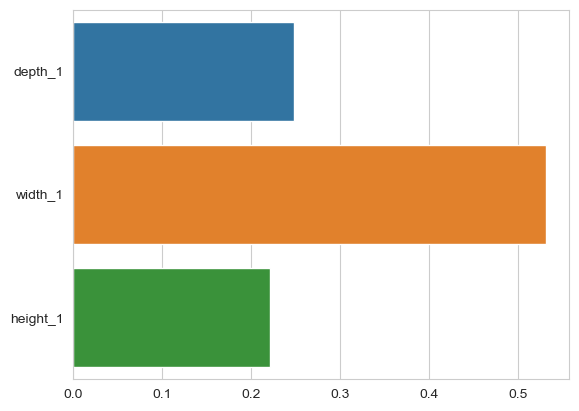

In [117]:
# візуалізація для RandomForestRegressor
sns.set_style('whitegrid')
sns.barplot(y=X_train.columns, x=forest_grid.best_estimator_.feature_importances_)

In [120]:
#Застосуємо GridSearchCV для DecisionTreeRegressor та налаштуємо гіперпараметри
from sklearn.model_selection import GridSearchCV

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X1, Y1, test_size=0.2, random_state=42)
decision_grid = GridSearchCV(DecisionTreeRegressor(), {'max_depth': [10,30,50,70,100,150,180,200,None]})
decision_grid.fit(X_train, Y_train)
 
print('Best Estimator :',decision_grid.best_estimator_)
print('Best Score     :',decision_grid.best_score_)
print('')
print('R^2            : {:.5f}'.format(sk.metrics.r2_score(Y_test, decision_grid.predict(X_test))))
print('MAE            : {:.5f}'.format(sk.metrics.mean_absolute_error(decision_grid.predict(X_test), Y_test)))
print('RMSE           : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(decision_grid.predict(X_test), Y_test))))
print('')
print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, decision_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

Best Estimator : DecisionTreeRegressor(max_depth=180)
Best Score     : 0.6894120061168596

R^2            : 0.68087
MAE            : 405.37972
RMSE           : 784.29082

Feature importance:
--------------------------------
0.20034    depth_1
0.62518    width_1
0.17449    height_1


<Axes: >

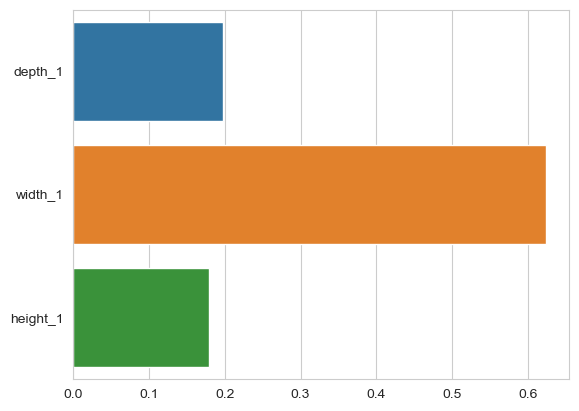

In [119]:
# візуалізація для DecisionTreeRegressor
sns.set_style('whitegrid')
sns.barplot(y=X_train.columns, x=decision_grid.best_estimator_.feature_importances_)

Проаналізувавши дані з датафрейму ikea,отримали, що найбільш впливовими колонками для формування цін є:
'width', 'depth', 'height'. 
При цьому значення вагових  коефіцієнтів таке:
для width - 0.53648   
для depth - 0.24536
для height - 0.21815

Використали такі регресійні моделі:KNeighborsRegressor,DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor.

Найкращою моделлю виявилась  RandomForestRegressor. 

Найкращий параметр для глибини дерева (max_depth) - 180, кількість ознак для кожного розбиття (max_features) - 'sqrt' та кількість дерев  - 130. Best Score :0.7780068474234811

R^2 (коефіцієнт детермінації)=0.75019. Він вказує, який відсоток мінливості залежної змінної може бути пояснений з використанням предикторів.

MAE=373.52259 вимірює середню абсолютну помилку між фактичними значеннями та передбаченими значеннями моделі.

RMSE=693.90712 (Root Mean Squared Error) є середньоквадратичною похибкою між прогнозованими і фактичними значеннями.

In [122]:
#змінимо розбивку даних на 70% для навчання та 30% для тестування і подивимося на результат

def getBestRegressor (X, Y):
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
    models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]
    
    TestModels = pd.DataFrame()
    res = {}
    tmp = {}

    for model in models:
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        model.fit(X_train, Y_train)
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model.predict(X_test), Y_test)))
        
        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])
        
    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res

In [123]:
X1 = ikea_df[['width_1','depth_1','height_1']]
Y1 = ikea_df['price']

test1 = getBestRegressor(X1, Y1)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.70645,387.32915,738.97573
GradientBoostingRegressor,0.65394,476.32892,802.36160
KNeighborsRegressor,0.59617,513.51819,866.74538
DecisionTreeRegressor,0.57658,471.56905,887.51683
LinearRegression,0.37200,677.86675,1080.87036
RidgeCV,0.37200,677.86678,1080.87039
LassoCV,0.37192,677.94324,1080.93897
SVR,0.33517,642.82111,1112.10648


In [124]:
#Застосуємо GridSearchCV та змінимо параметри
from sklearn.model_selection import GridSearchCV

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X1, Y1, test_size=0.3, random_state=42)
forest_grid = GridSearchCV(RandomForestRegressor(), {'n_estimators': [10,50, 100, 150,200, 300, 500], 
                                                     'max_depth': [30,70,100,180,200,None], 
                                                     'max_features': ['auto','sqrt','log2']}, cv=5, n_jobs=-1, verbose=0)
forest_grid.fit(X_train, Y_train)
 
print('Best Estimator :',forest_grid.best_estimator_)
print('Best Score     :',forest_grid.best_score_)
print('')
print('R^2            : {:.5f}'.format(sk.metrics.r2_score(Y_test, forest_grid.predict(X_test))))
print('MAE            : {:.5f}'.format(sk.metrics.mean_absolute_error(forest_grid.predict(X_test), Y_test)))
print('RMSE           : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(forest_grid.predict(X_test), Y_test))))
print('')
print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, forest_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomFore

Best Estimator : RandomForestRegressor(max_depth=100, max_features='log2', n_estimators=150)
Best Score     : 0.7632251585079788

R^2            : 0.71783
MAE            : 381.92894
RMSE           : 724.51270

Feature importance:
--------------------------------
0.53917    width_1
0.24091    depth_1
0.21992    height_1


Змінивши кількісне відношення розбивки даних та параметри, отримали:
найкращою регресійною моделлю залишилась RandomForestRegressor
для розбивки даних 80% на 20% показники такі:
max_depth=100, max_features='log2', n_estimators=150,  
Best Score: 0.7632251585079788
R^2: 0.71783, MAE: 381.92894, RMSE: 724.51270
width:0.53917, depth:0.24091, heigth:0.21992

для розбивки даних 70% на 30% показники такі:
max_depth=180, max_features='sqrt', n_estimators=130, 
Best Score: 0.7780068474234811
R^2: 0.75019, MAE: 373.52259, RMSE: 693.90712
width:0.53648, depth:0.24536, heigth:0.21815

отримані результати вказують на те, що перший варіант розбивки даних і налаштування параметрів більш ефективний. 

In [125]:
# Cross_Validation for KNeighborsRegressor
X = ikea_df[['width_1','depth_1','height_1']]
Y = ikea_df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
n_neighbors = {'n_neighbors': [i for i in range(1, 50)]}

%timeit
model = KNeighborsRegressor()
grid_search = GridSearchCV(model, n_neighbors, cv=5, n_jobs= -1)
grid_search.fit(X_train, Y_train)

print("Best value for k:", grid_search.best_params_['n_neighbors'])
print("Accuracy:", grid_search.best_score_)

Best value for k: 4
Accuracy: 0.6885723093173789


In [128]:
# Cross_Validation for RandomForestRegressor
start = datetime.datetime.now()
parameters = {'n_estimators': [10, 20, 30, 50],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']
              }

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, parameters, cv = 5, n_jobs= -1 )
grid_search.fit(X_train, Y_train)

end = datetime.datetime.now()
print(end - start )
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomFore

0:00:16.360348
Best Parameters:  {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Best Score:  0.7774319464816182
